In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate, Dropout, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




import os
import glob

In [3]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [184]:
# network parameters
width = 64
height = 64
latent_dim = 100

n_conds = 40
h = 0
w = 0
c = 0



# VAE model = encoder + decoder
def build_encoder():
    global h
    global w
    global c
    # build encoder model
    inputs = Input(shape=(width,height,3), name='encoder_input')
    condition_inputs = Input(shape=(n_conds,), name='encoder_cond_input')


    # x = GaussianNoise(1)(inputs) #Noise layer for denoising VAE
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    (_,h,w,c) = x.shape

    x = Flatten()(x)
    x = Concatenate()([x, condition_inputs])


    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    return Model([inputs,condition_inputs], [z_mean, z_log_var, z], name='encoder')
encoder = build_encoder()
encoder.summary()


def build_decoder():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    decoder_condition = Input(shape=(n_conds,), name='decoder_condition')



    x = Concatenate()([latent_inputs,decoder_condition])
    x = Dense(h*w*c)(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((h,w,c))(x)


    x = UpSampling2D()(x)
    x = Conv2D(256,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = UpSampling2D()(x)
    x = Conv2D(128,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # 



    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = UpSampling2D()(x)



    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)






    outputs_hi = Conv2D(3,5, strides=1, activation='tanh', padding='same')(x)


    # # instantiate decoder model
    return Model([latent_inputs,decoder_condition], outputs_hi, name='decoder')
decoder = build_decoder()
decoder.summary()








Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_234 (Conv2D)             (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 32, 32, 32)   128         conv2d_234[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_234 (LeakyReLU)     (None, 32, 32, 32)   0           batch_normalization_208[0][0]    
____________________________________________________________________________________________

In [5]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [6]:
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [7]:
# Rough feature model
dfc_lo_layers = ["block3_conv1"]
#dfc_layer_weights = [1.0/3.0, 1.0/3.0, 1.0/3.0]

dfc_lo_outputs = [vgg19.get_layer(l).output for l in dfc_lo_layers]
dfc_lo_loss_model = Model(vgg19.input, dfc_lo_outputs, name="dfc_lo_model")
dfc_lo_loss_model.summary()

Model: "dfc_lo_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

In [8]:
# Medium feature model

dfc_med_layers = ["block2_conv1"]
#dfc_layer_weights = [1.0/3.0, 1.0/3.0, 1.0/3.0]

dfc_med_outputs = [vgg19.get_layer(l).output for l in dfc_med_layers]
dfc_med_loss_model = Model(vgg19.input, dfc_med_outputs, name="dfc_med_model")
dfc_med_loss_model.summary()

Model: "dfc_med_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Fine feature model
dfc_hi_layers = ["block1_conv1"]
#dfc_layer_weights = [1.0/3.0, 1.0/3.0, 1.0/3.0]

dfc_hi_outputs = [vgg19.get_layer(l).output for l in dfc_hi_layers]
dfc_hi_loss_model = Model(vgg19.input, dfc_hi_outputs, name="dfc_hi_model")
dfc_hi_loss_model.summary()

Model: "dfc_hi_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Fine feature model
dfc_layers = ["block1_conv1","block2_conv1","block3_conv1"]
#dfc_layer_weights = [1.0/3.0, 1.0/3.0, 1.0/3.0]

dfc_outputs = [vgg19.get_layer(l).output for l in dfc_layers]
dfc_loss_model = Model(vgg19.input, dfc_outputs, name="dfc_model")
dfc_loss_model.summary()

Model: "dfc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0 

In [38]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [40]:
df = pd.read_csv('./celeba-attribs.csv')

In [143]:
training_data_generator = ImageDataGenerator(
    validation_split=0.0,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='training',
    shuffle=True,
    batch_size=10000,
    class_mode='raw')

Found 202599 validated image filenames.


In [39]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present > 0:
            print(attrib, present)

In [144]:
training_data = training_generator.next()

In [74]:
bce = tf.keras.losses.BinaryCrossentropy()
bce_smooth = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

@tf.function
def prep_for_vgg19(imgs):
    return ((imgs + 1) / 2)

@tf.function
def tanh_cross_entropy(y_true, y_pred):
    return -K.mean( (y_true+1)/2 * K.log( (y_pred+1)/2 + K.epsilon()) + (1 - (y_true+1)/2) * K.log(1 - (y_pred+1)/2 + K.epsilon()))
    

@tf.function
def kullback_leibler_divergence_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(kl_loss)

@tf.function
def discriminator_loss(real_output, decoded_output, fake_output):
    real_loss = bce(K.random_uniform(K.int_shape(real_output), minval=0.9, maxval=1.0), real_output)
    decoded_loss = bce(K.random_uniform(K.int_shape(decoded_output), minval=0.0, maxval=0.1), decoded_output)
    fake_loss = bce(K.random_uniform(K.int_shape(fake_output), minval=0.0, maxval=0.1), fake_output)
    total_loss = real_loss + fake_loss + decoded_loss
    return K.mean(total_loss)

@tf.function
def generator_loss(decoded_output, fake_output):
    decoded_loss = bce(K.ones_like(decoded_output), decoded_output)
    fake_loss = bce(K.ones_like(fake_output), fake_output)
    total_loss = fake_loss + decoded_loss
    return K.mean(total_loss)

@tf.function
def attribute_loss(true_attributes, predicted_attributes):
    total_loss = tanh_cross_entropy(true_attributes, predicted_attributes)    
    return K.mean(total_loss)

@tf.function
def discriminator_attrib_loss(true_attribs, real_attribs, decoded_attribs, fake_attribs):
    smoothing = K.random_uniform(K.int_shape(true_attribs), minval=0.9, maxval=1.0)
    real_loss = tanh_cross_entropy(true_attribs * smoothing, real_attribs)
    decoded_loss = tanh_cross_entropy(-true_attribs * smoothing, decoded_attribs)
    fake_loss = tanh_cross_entropy(-true_attribs * smoothing, fake_attribs)
    total_loss = real_loss + fake_loss + decoded_loss
    return K.mean(total_loss)

@tf.function
def generator_attrib_loss(true_attribs, decoded_attribs, fake_attribs):
    decoded_loss = tanh_cross_entropy(true_attribs, decoded_attribs)
    fake_loss = tanh_cross_entropy(true_attribs, fake_attribs)
    total_loss = fake_loss + decoded_loss
    return K.mean(total_loss)


@tf.function
def reconstruction_loss(y_true, y_pred):
    return tanh_cross_entropy(y_true, y_pred)


@tf.function
def perceptual_loss(real_image, predicted_image, dfc_loss_model):

    h1_hi, h1_med, h1_lo = dfc_loss_model(real_image)
    h2_hi, h2_med, h2_lo = dfc_loss_model(predicted_image)
    

    

    h1_hi = K.batch_flatten(h1_hi)
    h2_hi = K.batch_flatten(h2_hi)        
    rc_loss_hi = mse(h1_hi, h2_hi)
    
    h1_med = K.batch_flatten(h1_med)
    h2_med = K.batch_flatten(h2_med)        
    rc_loss_med = mse(h1_med, h2_med)
    
    h1_lo = K.batch_flatten(h1_lo)
    h2_lo = K.batch_flatten(h2_lo)        
    rc_loss_lo = mse(h1_lo, h2_lo)
    

    
    return K.mean(rc_loss_hi), K.mean(rc_loss_med), K.mean(rc_loss_lo)       



In [301]:


@tf.function
def train_step(images, attributes, beta):
    


    rl_scalar = 1.0
    kl_scalar =  beta

    
    with tf.GradientTape() as dec_tape, tf.GradientTape() as enc_tape:

     
        dec_tape.watch(decoder.trainable_variables)
        enc_tape.watch(encoder.trainable_variables)

        
        z_mean, z_log_var, z = encoder([images,attributes], training=True)        
        decoded_images_combo = decoder([z, attributes], training=True)
        
        kl_loss = kullback_leibler_divergence_loss(z_mean, z_log_var)
        


        
        
        rl_hi, rl_med, rl_lo =  perceptual_loss(decoded_images_combo,  images, dfc_loss_model)
        
        # for balance
        rl_hi = 8.0 * rl_hi
        rl_med = 0.2 * rl_med
        rl_lo = 0.1 * rl_lo
        
        rl_loss = rl_lo +  rl_med + rl_hi
        
          

        
        decoder_loss = rl_loss * rl_scalar 

        encoder_loss = kl_loss * beta + rl_loss * rl_scalar
        





    gradients_of_encoder = enc_tape.gradient(encoder_loss, encoder.trainable_variables)
    gradients_of_decoder = dec_tape.gradient(decoder_loss, decoder.trainable_variables)
    
    
    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
    decoder_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))


    

    

    return rl_lo, rl_med, rl_hi, kl_loss, beta



In [300]:
encoder = build_encoder()
decoder = build_decoder()
decoder_optimizer = tf.keras.optimizers.Adam(2e-4)
encoder_optimizer = tf.keras.optimizers.Adam(2e-4)


Epoch [0/49]...     ...17.158(s) feat_lo: 2.20271 - feat_med: 1.71565 - feat_hi: 1.68038 - KL: 25.21321 - 
5_o_Clock_Shadow 1
Attractive 1
Big_Lips 1
Black_Hair 1
Bushy_Eyebrows 1
Male 1
Mustache 1
Pointy_Nose 1
Wavy_Hair 1
Young 1


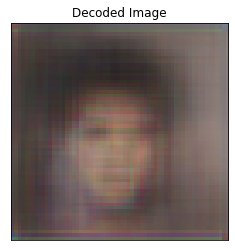

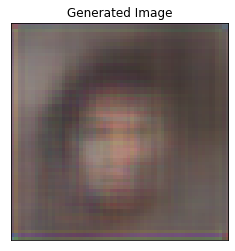

Epoch [1/49]...     ...11.702(s) feat_lo: 1.72924 - feat_med: 1.39209 - feat_hi: 1.19020 - KL: 25.36471 - 
Epoch [2/49]...     ...11.774(s) feat_lo: 1.63492 - feat_med: 1.33125 - feat_hi: 1.12615 - KL: 25.08670 - 
Epoch [3/49]...     ...11.731(s) feat_lo: 1.57787 - feat_med: 1.29451 - feat_hi: 1.08801 - KL: 25.05224 - 
Epoch [4/49]...     ...11.740(s) feat_lo: 1.53569 - feat_med: 1.26662 - feat_hi: 1.05808 - KL: 24.99667 - 
Epoch [5/49]...     ...11.724(s) feat_lo: 1.50399 - feat_med: 1.24514 - feat_hi: 1.03724 - KL: 25.05675 - 
Epoch [6/49]...     ...11.741(s) feat_lo: 1.47874 - feat_med: 1.22822 - feat_hi: 1.02172 - KL: 25.01971 - 
Epoch [7/49]...     ...11.750(s) feat_lo: 1.45513 - feat_med: 1.21283 - feat_hi: 1.00773 - KL: 25.04771 - 
Epoch [8/49]...     ...11.719(s) feat_lo: 1.43706 - feat_med: 1.19949 - feat_hi: 0.99500 - KL: 25.00638 - 
Epoch [9/49]...     ...11.701(s) feat_lo: 1.42133 - feat_med: 1.18886 - feat_hi: 0.98570 - KL: 24.99902 - 
Epoch [10/49]...    ...11.762(s) feat

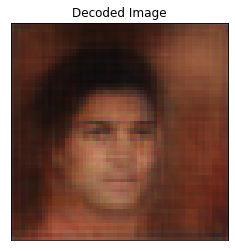

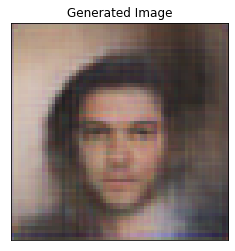

Epoch [11/49]...    ...11.677(s) feat_lo: 1.39287 - feat_med: 1.16833 - feat_hi: 0.96802 - KL: 25.05216 - 
Epoch [12/49]...    ...11.700(s) feat_lo: 1.38377 - feat_med: 1.16298 - feat_hi: 0.96399 - KL: 24.99069 - 
Epoch [13/49]...    ...11.679(s) feat_lo: 1.37142 - feat_med: 1.15372 - feat_hi: 0.95785 - KL: 25.02497 - 
Epoch [14/49]...    ...11.720(s) feat_lo: 1.36428 - feat_med: 1.14853 - feat_hi: 0.95455 - KL: 25.00489 - 
Epoch [15/49]...    ...11.672(s) feat_lo: 1.35668 - feat_med: 1.14294 - feat_hi: 0.95041 - KL: 25.02243 - 
Epoch [16/49]...    ...11.739(s) feat_lo: 1.34801 - feat_med: 1.13701 - feat_hi: 0.94472 - KL: 24.98280 - 
Epoch [17/49]...    ...11.706(s) feat_lo: 1.34050 - feat_med: 1.13200 - feat_hi: 0.94143 - KL: 25.04645 - 
Epoch [18/49]...    ...11.637(s) feat_lo: 1.33429 - feat_med: 1.12739 - feat_hi: 0.93738 - KL: 25.04592 - 
Epoch [19/49]...    ...11.735(s) feat_lo: 1.32776 - feat_med: 1.12264 - feat_hi: 0.93344 - KL: 24.99795 - 
Epoch [20/49]...    ...11.694(s) feat

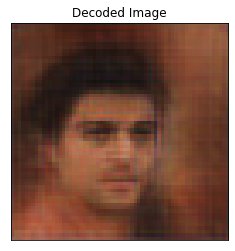

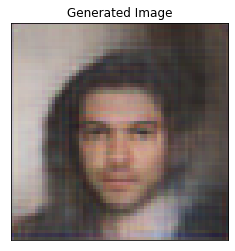

Epoch [21/49]...    ...11.688(s) feat_lo: 1.31621 - feat_med: 1.11438 - feat_hi: 0.92730 - KL: 24.95763 - 
Epoch [22/49]...    ...11.639(s) feat_lo: 1.31351 - feat_med: 1.11178 - feat_hi: 0.92606 - KL: 25.04686 - 
Epoch [23/49]...    ...11.695(s) feat_lo: 1.30798 - feat_med: 1.10753 - feat_hi: 0.92286 - KL: 25.01121 - 
Epoch [24/49]...    ...11.697(s) feat_lo: 1.30170 - feat_med: 1.10379 - feat_hi: 0.92146 - KL: 25.00432 - 
Epoch [25/49]...    ...11.665(s) feat_lo: 1.30055 - feat_med: 1.10290 - feat_hi: 0.92090 - KL: 25.03904 - 
Epoch [26/49]...    ...11.600(s) feat_lo: 1.29333 - feat_med: 1.09682 - feat_hi: 0.91493 - KL: 24.99897 - 
Epoch [27/49]...    ...11.618(s) feat_lo: 1.29030 - feat_med: 1.09552 - feat_hi: 0.91479 - KL: 24.97864 - 
Epoch [28/49]...    ...11.610(s) feat_lo: 1.28565 - feat_med: 1.09091 - feat_hi: 0.91009 - KL: 25.02482 - 
Epoch [29/49]...    ...11.683(s) feat_lo: 1.28262 - feat_med: 1.08936 - feat_hi: 0.91009 - KL: 24.99290 - 
Epoch [30/49]...    ...11.673(s) feat

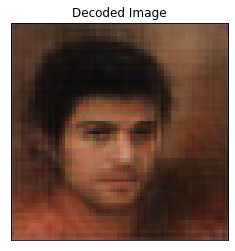

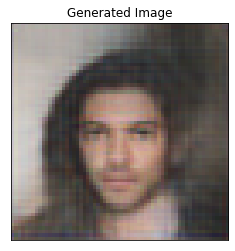

Epoch [31/49]...    ...11.678(s) feat_lo: 1.27419 - feat_med: 1.08270 - feat_hi: 0.90498 - KL: 24.99119 - 
Epoch [32/49]...    ...11.691(s) feat_lo: 1.27372 - feat_med: 1.08244 - feat_hi: 0.90507 - KL: 25.02915 - 
Epoch [33/49]...    ...11.680(s) feat_lo: 1.26872 - feat_med: 1.07877 - feat_hi: 0.90272 - KL: 25.03611 - 
Epoch [34/49]...    ...11.591(s) feat_lo: 1.26552 - feat_med: 1.07598 - feat_hi: 0.89905 - KL: 24.96941 - 
Epoch [35/49]...    ...11.630(s) feat_lo: 1.26181 - feat_med: 1.07319 - feat_hi: 0.89718 - KL: 25.02212 - 
Epoch [36/49]...    ...11.638(s) feat_lo: 1.25976 - feat_med: 1.07168 - feat_hi: 0.89750 - KL: 24.96396 - 
Epoch [37/49]...    ...11.663(s) feat_lo: 1.25553 - feat_med: 1.06847 - feat_hi: 0.89418 - KL: 25.05588 - 
Epoch [38/49]...    ...11.683(s) feat_lo: 1.25430 - feat_med: 1.06702 - feat_hi: 0.89223 - KL: 24.97763 - 
Epoch [39/49]...    ...11.626(s) feat_lo: 1.25043 - feat_med: 1.06433 - feat_hi: 0.89067 - KL: 25.00797 - 
Epoch [40/49]...    ...11.616(s) feat

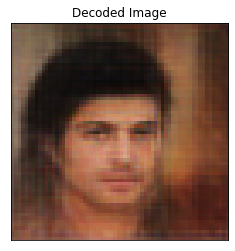

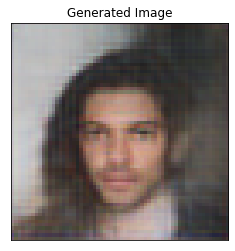

Epoch [41/49]...    ...11.612(s) feat_lo: 1.24561 - feat_med: 1.06061 - feat_hi: 0.88789 - KL: 25.00717 - 
Epoch [42/49]...    ...11.633(s) feat_lo: 1.24115 - feat_med: 1.05733 - feat_hi: 0.88616 - KL: 24.97817 - 
Epoch [43/49]...    ...11.661(s) feat_lo: 1.24010 - feat_med: 1.05686 - feat_hi: 0.88584 - KL: 25.01279 - 
Epoch [44/49]...    ...11.666(s) feat_lo: 1.23891 - feat_med: 1.05569 - feat_hi: 0.88523 - KL: 25.01409 - 
Epoch [45/49]...    ...11.715(s) feat_lo: 1.23399 - feat_med: 1.05207 - feat_hi: 0.88193 - KL: 24.97668 - 
Epoch [46/49]...    ...11.714(s) feat_lo: 1.23327 - feat_med: 1.05078 - feat_hi: 0.88079 - KL: 25.03173 - 
Epoch [47/49]...    ...11.684(s) feat_lo: 1.22943 - feat_med: 1.04748 - feat_hi: 0.87745 - KL: 24.99582 - 
Epoch [48/49]...    ...11.642(s) feat_lo: 1.22878 - feat_med: 1.04750 - feat_hi: 0.87888 - KL: 25.01575 - 
Epoch [49/49]...    ...11.632(s) feat_lo: 1.22557 - feat_med: 1.04447 - feat_hi: 0.87598 - KL: 24.96209 - 


In [302]:
import time
from pathlib import Path

epochs = 50
batch_size = 64

# control vae params
k_p = 0.01
k_i = 0.0001
i_t = 0
beta_max = 1.0 
beta_min = 0.0
desired_kl = 25
beta = 0.0




model_type = '10kimgs-controlled-kl-dfc-cvae'




#create base dir
base_model_path = Path(f'./models/{model_type}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    training_imgs = training_data[0]
    training_attribs = training_data[1]
    training_attribs  = np.cast['float32'](training_attribs )

    num_batches = len(training_imgs) // batch_size

    # losses
    rl_lo_loss_list = [] 
    rl_med_loss_list = [] 
    rl_hi_loss_list = [] 
    kl_loss_list = []

    
    test_attribute = training_data[1][0]
    test_img = training_data[0][0]
    mu, sigma = 0, 1 #mean and standard deviation
    s = np.random.normal(mu, sigma, latent_dim)
    

    

    


    for epoch in range(0,epochs):
        start = time.time()
        print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')


        
        idxs = np.arange(0,len(training_imgs))
        np.random.shuffle(idxs)
        
        img_input = training_imgs[idxs]
        attribute_input = training_attribs[idxs]


        rl_lo_loss_total = 0
        rl_med_loss_total = 0
        rl_hi_loss_total = 0
        kl_loss_total = 0

         

        
        
        for index in range(num_batches):
            img_batch = img_input[index*batch_size: batch_size*(index+1)]
            attribute_batch = attribute_input[index*batch_size: batch_size*(index+1)] 
            

            rl_lo_loss, rl_med_loss, rl_hi_loss, kl_loss, beta_num = train_step(img_batch , attribute_batch, tf.constant(beta, dtype=tf.float32))


            rl_lo_loss_total += K.get_value(rl_lo_loss)
            rl_med_loss_total += K.get_value(rl_med_loss)
            rl_hi_loss_total += K.get_value(rl_hi_loss)
            kl_loss_total += K.get_value(kl_loss)


#             print(f'kl: { K.get_value(kl_loss):.5f} beta: {K.get_value(beta_var):.5f}')
#             control vae 
            error_t = desired_kl - K.get_value(kl_loss)
            p_t = k_p / (1+np.exp(error_t))

            if beta_min <= beta and beta <= beta_max:
                i_t = i_t - k_i*error_t

            beta = p_t + i_t + beta_min

            beta = min(beta, beta_max)
            beta = max(beta, beta_min)


        
        
       
        
        rl_lo_loss_list.append(rl_lo_loss_total/num_batches) 
        rl_med_loss_list.append(rl_med_loss_total/num_batches) 
        rl_hi_loss_list.append(rl_hi_loss_total/num_batches)
        kl_loss_list.append(kl_loss_total/num_batches)



        print(f'...{time.time()-start:.3f}(s) '  , end='')
       
        
        print(f'feat_lo: {rl_lo_loss_total/num_batches:.5f} - ', end='') 
        print(f'feat_med: {rl_med_loss_total/num_batches:.5f} - ', end='') 
        print(f'feat_hi: {rl_hi_loss_total/num_batches:.5f} - ', end='') 
        
        print(f'KL: {kl_loss_total/num_batches:.5f} - ')
#         print(f'beta: {K.get_value(beta_var)}')
        

        if epoch % 10 == 0:
            encode_to_attribs(test_attribute)
            _, _, z = encoder.predict([training_data[0][0].reshape(1,width, height,3), test_attribute.reshape(1,-1)])
            dec_img = unnormalize_tanh( decoder.predict([z, test_attribute.reshape(1,n_conds)])[0])
            plt.imshow(dec_img)
            plt.title("Decoded Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'decoded-{epoch}.png')
            plt.show()
            
            gen_img = unnormalize_tanh( decoder.predict([np.array([s]),np.array([test_attribute])])[0])        
            plt.imshow(gen_img)
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


#         if epoch % 100 == 0 and epoch != 0:        
#             print(f'checkpointing at epoch: {epoch}')
#             decoder.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-decoder-weights.h5').as_posix())
#             decoder.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-decoder.h5').as_posix())
#             encoder.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-encoder-weights.h5').as_posix())
#             encoder.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-encoder.h5').as_posix())
            

In [78]:
def normalize(loss_list):
    loss_list = np.array(loss_list)
    return (loss_list - loss_list.min()) / (loss_list.max() - loss_list.min())

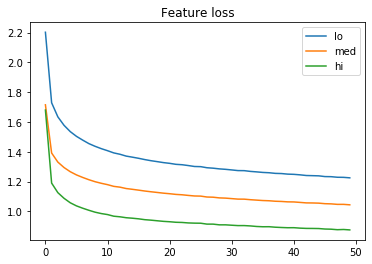

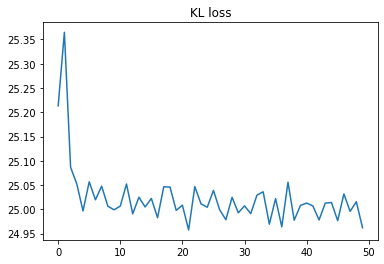

In [303]:


plt.plot(rl_lo_loss_list, label="lo")
plt.plot(rl_med_loss_list, label="med")
plt.plot(rl_hi_loss_list, label="hi")
plt.title("Feature loss")
plt.legend()
plt.savefig(figure_model_path / 'feature_loss.png')
plt.show()
 
plt.plot(kl_loss_list)
plt.title("KL loss")
plt.savefig(figure_model_path / 'encoder_loss.png')
plt.show()


In [196]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label

In [197]:
attribs = '''5oClockShadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young'''
attribs = attribs.split('=1,')
attribs = [attrib.strip() for attrib in attribs]
print(f"=1, ".join(attribs))

5oClockShadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young


In [82]:
attrib_dict = {attrib:i for i,attrib in enumerate(attribs)}

In [83]:
def generate(decoder, noise, attribute):
    gen_img = unnormalize_tanh( decoder.predict([np.array([noise]),np.array([attribute])])[0])        
    plt.imshow(gen_img)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [84]:
sliders = []
labels = []
for attrib in attribs:
    slider = widgets.FloatSlider(
        min=-10,
        max=10,
        step=0.5,
        value=-1    )
    labels.append(Label(attrib))
    sliders.append(slider)
for label, slider in zip(labels,sliders):
    display(label)
    display(slider)

Label(value='5oClockShadow')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Arched_Eyebrows')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Attractive')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Bags_Under_Eyes')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Bald')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Bangs')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Big_Lips')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Big_Nose')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Black_Hair')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Blond_Hair')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Blurry')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Brown_Hair')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Bushy_Eyebrows')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Chubby')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Double_Chin')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Eyeglasses')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Goatee')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Gray_Hair')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Heavy_Makeup')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='High_Cheekbones')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Male')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Mouth_Slightly_Open')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Mustache')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Narrow_Eyes')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='No_Beard')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Oval_Face')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Pale_Skin')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Pointy_Nose')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Receding_Hairline')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Rosy_Cheeks')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Sideburns')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Smiling')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Straight_Hair')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Wavy_Hair')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Wearing_Earrings')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Wearing_Hat')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Wearing_Lipstick')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Wearing_Necklace')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Wearing_Necktie')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Label(value='Young')

FloatSlider(value=-1.0, max=10.0, min=-10.0, step=0.5)

Bald 1.0
Blond_Hair 1.0
Male 1.5
Mouth_Slightly_Open 1.0
Narrow_Eyes 1.0
No_Beard 1.0
Oval_Face 1.0
Pale_Skin 1.0
Rosy_Cheeks 1.0
Smiling 1.0
Wavy_Hair 1.0
Young 1.0


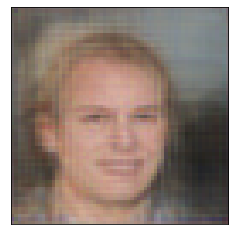

In [381]:
conditions = np.array([slider.value for slider in sliders])
# conditions = test_attribute
# conditions = training_attribs[101]
encode_to_attribs(conditions)
mu, sigma = 0, 1 #mean and standard deviation
noise = np.random.normal(mu, sigma,100)
generate(decoder,noise,conditions)
